# Проект 7. Ford vs Ferrari

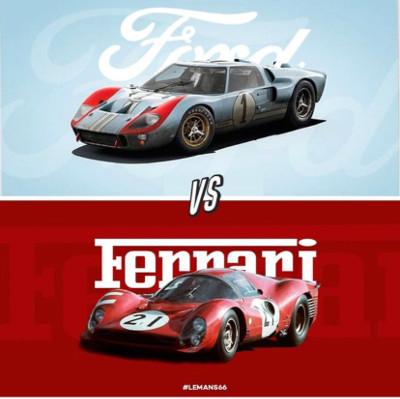

**Цель проекта** Взять предобученую на ImageNet сеть и дообучить под нашу задачу распознавания марок машин.

Основано на: Baseline Keras Xception [Car class] v2.0

## 1. Импорт библиотек и ключевые параметры

In [1]:
!pip install -q efficientnet

!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-ljag9_96
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-ljag9_96
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=1bfb7d1daeea0303e2b04c793bdde437534679769855c74fc9903a9b14612192
  Stored in directory: /tmp/pip-ephem-wheel-cache-6h50etkw/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from ImageDataAugmentor.image_data_augmentor import *
import albumentations
import efficientnet.tfkeras as efn

import PIL
from PIL import ImageOps, ImageFilter

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [3]:
!nvidia-smi

Tue Mar 30 09:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip freeze > requirements.txt

### Основные параметры

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5   # эпох на обучение
BATCH_SIZE           = 16  # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = '../working/car/'   # рабочая директория

# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

---
## 2. Загрузка и первичная предобработка данных

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


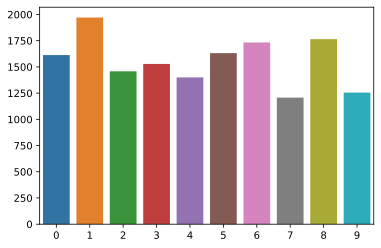

In [8]:
# Распределение классов достаточно равномерное - это хорошо

value_counts = train_df.Category.value_counts()

sns.barplot(x = value_counts.index,
             y = value_counts.values);

In [9]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


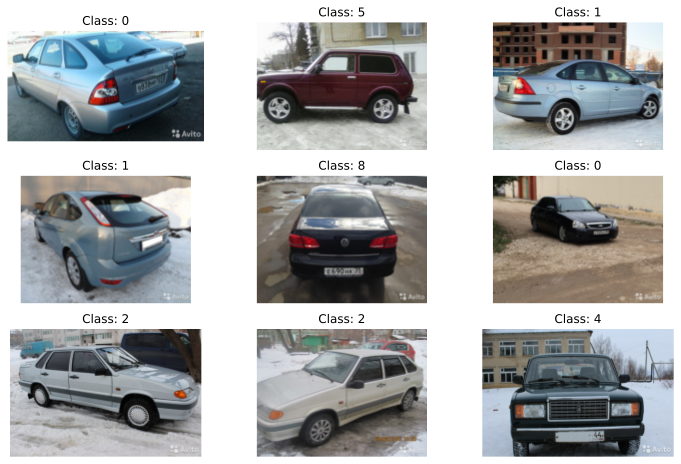

In [10]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

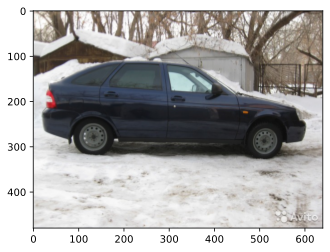

(640, 480)

In [11]:
# Посмотрим на пример картинки и её размеры чтоб понимать как лучше обработать и сжимать.

image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

---
## 3. Подготовка данных

### 3.1 Аугментация данных

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
)
        
test_datagen = ImageDataAugmentor(rescale=1./255)

### 3.2 Генерация данных

In [13]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


### 3.3 Образцы искусственно созданных изображений

Пример изображений (train_generator)


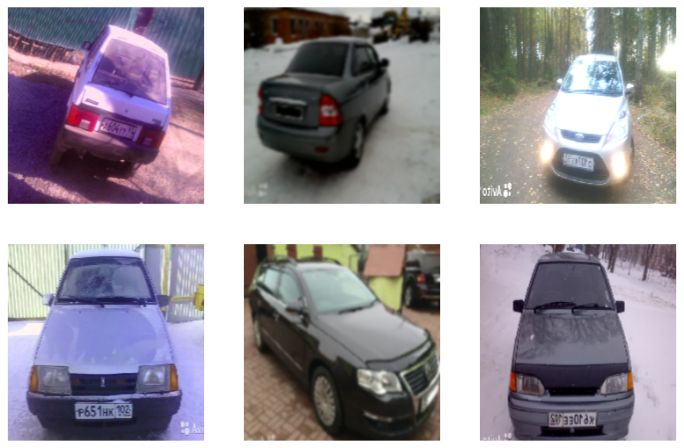

In [14]:
print('Пример изображений (train_generator)')
plt.figure(figsize=(12,8))

x,y = train_generator.next()

for i in range(6):
    plt.subplot(2,3, i + 1)
    plt.imshow(x[i])
    plt.axis('off')
plt.show()

---
## 4. Построение модели
По совокупности факторов (точность, быстродействие, требовательность к ресурсам) методом научного тыка выбор модели пал на EfficientNetB7 (https://sotabench.com/benchmarks/image-classification-on-imagenet).

In [15]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.summary()

258441216/258434480 [==============================] - 5s 0us/step
Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
_________________

block5c_drop (FixedDropout)     (None, 14, 14, 224)  0           block5c_project_bn[0][0]         
__________________________________________________________________________________________________
block5c_add (Add)               (None, 14, 14, 224)  0           block5c_drop[0][0]               
                                                                 block5b_add[0][0]                
__________________________________________________________________________________________________
block5d_expand_conv (Conv2D)    (None, 14, 14, 1344) 301056      block5c_add[0][0]                
__________________________________________________________________________________________________
block5d_expand_bn (BatchNormali (None, 14, 14, 1344) 5376        block5d_expand_conv[0][0]        
__________________________________________________________________________________________________
block5d_expand_activation (Acti (None, 14, 14, 1344) 0           block5d_expand_bn[0][0]          
__________

In [16]:
# Устанавливаем новую "голову" (head)

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', bias_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

predictions = Dense(CLASS_NUM, activation='softmax')(x)

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

block7a_se_reduce (Conv2D)      (None, 1, 1, 96)     221280      block7a_se_reshape[0][0]         
__________________________________________________________________________________________________
block7a_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block7a_se_reduce[0][0]          
__________________________________________________________________________________________________
block7a_se_excite (Multiply)    (None, 7, 7, 2304)   0           block7a_activation[0][0]         
                                                                 block7a_se_expand[0][0]          
__________________________________________________________________________________________________
block7a_project_conv (Conv2D)   (None, 7, 7, 640)    1474560     block7a_se_excite[0][0]          
__________________________________________________________________________________________________
block7a_project_bn (BatchNormal (None, 7, 7, 640)    2560        block7a_project_conv[0][0]       
__________

---
## 5. Обучение модели

### 5.1 Первичный прогон (подготовка к Transfer Learning)

Для начала прогоним модель с обученными на EfficientNetB7, чтобы не затереть веса "головы".

In [18]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor=['val_accuracy'],
                             verbose=1,
                             mode = 'max'
)

earlystop = EarlyStopping(
                            monitor='accuracy',
                            patience=5,
                            restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.25,
                            patience=2,
                            min_lr=0.0000001,
                            verbose=1,
                            mode='auto'
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [19]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
779/779 [==============================] - 541s 653ms/step - loss: 2.1857 - accuracy: 0.3029 - val_loss: 0.4482 - val_accuracy: 0.8392

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
779/779 [==============================] - 504s 646ms/step - loss: 0.6741 - accuracy: 0.7684 - val_loss: 0.2724 - val_accuracy: 0.9061

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
779/779 [==============================] - 505s 648ms/step - loss: 0.4254 - accuracy: 0.8490 - val_loss: 0.2090 - val_accuracy: 0.9292

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
779/779 [==============================] - 504s 647ms/step - loss: 0.3186 - accuracy: 0.8904 - val_loss: 0.1839 - val_accuracy: 0.9411

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
779/779 [==============================] - 503s 646ms/step - loss: 0.2837 - accuracy: 0.9008 - val_loss: 0.1715 - val_accuracy: 0.9466

Epoch 00005: saving model to best_model.hdf5


In [20]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [21]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


195/195 [==============================] - 38s 191ms/step - loss: 0.1760 - accuracy: 0.9453
Accuracy: 94.53%


### 5.2 Визуализация процесса обучения

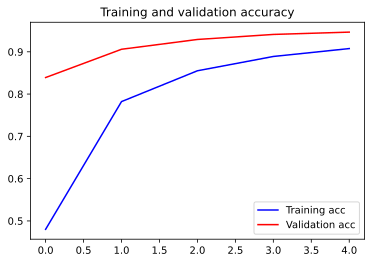

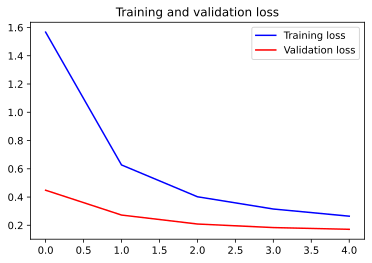

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### 5.3 Повторный прогон - FineTuning с частичной разморозкой сети и дообучением

In [23]:
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2


# Заморозим половину весов модели-шаблона

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [24]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//BATCH_SIZE,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
778/778 [==============================] - 272s 321ms/step - loss: 0.2471 - accuracy: 0.9184 - val_loss: 0.1690 - val_accuracy: 0.9485

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
778/778 [==============================] - 246s 316ms/step - loss: 0.1918 - accuracy: 0.9337 - val_loss: 0.1670 - val_accuracy: 0.9494

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
778/778 [==============================] - 246s 317ms/step - loss: 0.1954 - accuracy: 0.9329 - val_loss: 0.1437 - val_accuracy: 0.9539

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
778/778 [==============================] - 246s 316ms/step - loss: 0.1546 - accuracy: 0.9457 - val_loss: 0.1627 - val_accuracy: 0.9504

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
778/778 [==============================] - 246s 316ms/step - loss: 0.1369 - accuracy: 0.9528 - val_loss: 0.1590 - val_accuracy: 0.9543

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing lear

In [25]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [26]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

195/195 [==============================] - 37s 187ms/step - loss: 0.1643 - accuracy: 0.9524
Accuracy: 95.24%


### 5.4 Последний прогон - полная разморозка сети с дообучением

In [27]:
base_model.trainable = True

In [28]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

# Уменьшим объём в пакете (batch), иначе вылетает из-за нехватки памяти.

history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//(BATCH_SIZE * 2),
        validation_data = test_generator, 
        validation_steps = test_generator.samples//(BATCH_SIZE * 2),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
389/389 [==============================] - 287s 668ms/step - loss: 0.1417 - accuracy: 0.9480 - val_loss: 0.1567 - val_accuracy: 0.9517

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
389/389 [==============================] - 253s 651ms/step - loss: 0.1325 - accuracy: 0.9525 - val_loss: 0.1423 - val_accuracy: 0.9607

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
389/389 [==============================] - 255s 655ms/step - loss: 0.1339 - accuracy: 0.9558 - val_loss: 0.2029 - val_accuracy: 0.9459

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
389/389 [==============================] - 256s 658ms/step - loss: 0.1321 - accuracy: 0.9524 - val_loss: 0.1604 - val_accuracy: 0.9459

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 5/5
389/389 [==============================] - 257s 659ms/step - loss: 0.0979 - accuracy: 0.9649 - val_loss: 0.1374 - val_accuracy: 0.9607

Epoch 000

In [29]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

195/195 [==============================] - 37s 190ms/step - loss: 0.1427 - accuracy: 0.9588
Accuracy: 95.88%


---
## 6. Предсказание на тестовых данных

In [31]:
test_sub_generator.samples

6675

### 6.1 Test Time Augmentation

Воспользуемся TTA - немного видоизменим каждое из тестовых изображений и оценим принадлежность к классу по усреднённой оценке, полученной на аугментированных данных. 

In [32]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [33]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


418/418 [==============================] - 56s 134ms/step


### 6.2 Подготовка и сохранение данных для заливки

In [34]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [35]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [36]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [37]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

---
## 7. Итоги и выводы
* XCeption в бейслайне даже с одиночным прогоном показал высокий результат (93.6%)- его можно использовать "из коробки" для простых проектов с минимальной доработкой.
* Переход на EfficientNetB7 сам по себе улучшил результат до 95.3%, но вкупе с бОльшими требованиями к памяти и существенно более медленной обработкой это было бы не особо удачным решением в "живом" проекте.
* Добавление "дополнений" albuminations к моему удивлению снизило точность до 91.8%. 
* Добавление Batch Normalization дополнительно снизило точность до 90.5%.
* Смена оптимайзера на SGD вылилась в просевшую до 19% точность! (вернул назад на Adam)
* EarlyStop - callback-ф-ия повысила результат до 91.3%.
* TTA помогла - 93.1% на тесте.
* Добавление регуляризатора L2 и обработчика скорости обучения (ReduceLROnPlateau) дало ещё совокупный прирост в 0.3% (95.6% на обучении).
* Перенос обучения (transfer learning) с дообучением (fine-tuning) в данном примере хоть и помог, но не так существенно, как ожидал.
* В результате получил точность 96.1% на тесте.
* В общем и целом, проект получился интересным, но время на подготовку он занял существенно дольше из-за ожиданий результатов при обучении. Также не совсем интуитивно понятны оказались результаты изменений - какие-то даже ухудшали проект, хотя в теории должны были помочь: придётся ещё поиграться с ними на досуге.